# Detecting Sarcasam on Reddit Posts

# Inspecting the Data Set

In [ ]:
# Importing Required Libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings
warnings.filterwarnings("ignore")

from nltk.stem.snowball import EnglishStemmer

from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix 
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve, plot_precision_recall_curve
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Project/Sarcasm/train-balanced-sarcasm.csv')

In [ ]:
df.head()

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,NC and NH.,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.
3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz
4,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...


In [ ]:
# 53 Missing Values in Comments. 
# This is very miniscule and can be ignored since the size of our dataset is quite large
df.isna().sum()
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1010773 entries, 0 to 1010825
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   label           1010773 non-null  int64 
 1   comment         1010773 non-null  object
 2   author          1010773 non-null  object
 3   subreddit       1010773 non-null  object
 4   score           1010773 non-null  int64 
 5   ups             1010773 non-null  int64 
 6   downs           1010773 non-null  int64 
 7   date            1010773 non-null  object
 8   created_utc     1010773 non-null  object
 9   parent_comment  1010773 non-null  object
dtypes: int64(4), object(6)
memory usage: 84.8+ MB


In [ ]:
#inspecting which Subreddit contributes most to the data set
(df['subreddit'].value_counts()[df['subreddit'].value_counts()>5000]/len(df['label']) * 100)

AskReddit          6.497403
politics           3.907208
worldnews          2.609488
leagueoflegends    2.080982
pcmasterrace       1.878463
funny              1.774780
news               1.671097
pics               1.597985
todayilearned      1.400809
nfl                1.399820
nba                1.399523
GlobalOffensive    1.359158
AdviceAnimals      1.333831
videos             1.218869
gaming             1.177910
The_Donald         0.953330
WTF                0.945613
hockey             0.869038
soccer             0.836587
TumblrInAction     0.743589
atheism            0.729837
CFB                0.697288
movies             0.648019
DotA2              0.591626
technology         0.563133
creepyPMs          0.540774
india              0.524252
gifs               0.521086
DestinyTheGame     0.497738
Name: subreddit, dtype: float64

In [ ]:
# looking at the labels to make sure they are evenly distrubted
print('Label distribution')
(df['label'].value_counts())

Label distribution


0    505405
1    505368
Name: label, dtype: int64

In [ ]:
# We are inspecting the Data to see what the % is for subreddits that contain label 1 compared to the total number of comments.
df.groupby('subreddit')['label'].sum()/df['subreddit'].value_counts()*100

07Scape            0.000000
0x10c            100.000000
0x3642             0.000000
100DaysofKeto      0.000000
100pushups         0.000000
                    ...    
zoophilia        100.000000
zootopia          37.333333
zweiteliga       100.000000
zyramains         60.000000
zyzz              50.000000
Length: 14876, dtype: float64

 1       339997
 2       162669
 3        90287
 0        58141
 4        41978
          ...  
 1448         1
 1221         1
 709          1
-87           1
 5629         1
Name: score, Length: 1291, dtype: int64

count    1.010773e+06
mean     6.885999e+00
std      4.834411e+01
min     -5.070000e+02
25%      1.000000e+00
50%      2.000000e+00
75%      4.000000e+00
max      9.070000e+03
Name: score, dtype: float64



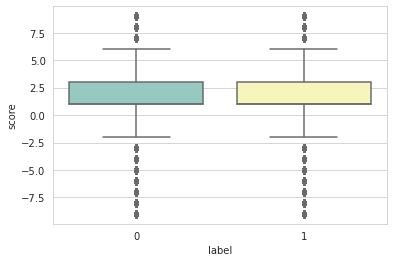

In [ ]:
# Inspecting to see if there is a realtionship between Score and the label given
print(df['score'].value_counts())
print()
print(df['score'].describe())
print()
sns.set_style("whitegrid")
ax = sns.boxplot(x="label", y="score",data=df[abs(df['score'])<10], palette="Set3")
# Based on the Boxplot we can see that there is no real impact on whether a comment is sarcastic or not
# based on the score therefore using scores would not be a effective way to detect sarcasam in comments.

- Based on the Above analysis we can say that the only real way to detect sarcasam is through the comment alone.
- Will take 100k subset to test out pre-proccessing


# **Textual Analysis**

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem.snowball import EnglishStemmer

stemmer = EnglishStemmer()
analyzer = CountVectorizer().build_analyzer()

def stemmed_words(doc):
    return (stemmer.stem(w) for w in analyzer(doc))


cv = CountVectorizer(min_df = 30, stop_words = 'english', strip_accents ='ascii',
                     ngram_range = (2,2)) # analyzer=stemmed_words

X = cv.fit_transform(df['comment'])
X

<1010773x6356 sparse matrix of type '<class 'numpy.int64'>'
	with 510153 stored elements in Compressed Sparse Row format>

In [ ]:
# collect the columns which are digits
digitcols = np.array([x.isdigit() for x in cv.get_feature_names()])
print('The number of digit columns is ',np.sum(digitcols))
print('The number of features is',len(cv.get_feature_names()))

The number of digit columns is  0
The number of features is 6356


In [ ]:
bag_words = pd.Series(np.asarray(X.sum(axis=0)).reshape(-1),index=cv.get_feature_names())
bag_words

000 000              172
000 people            70
000 year              40
000 years             77
10 000               135
                    ... 
youtube videos        64
yup just              65
yup totally           47
zero tolerance        34
zombie apocalypse     30
Length: 6356, dtype: int64

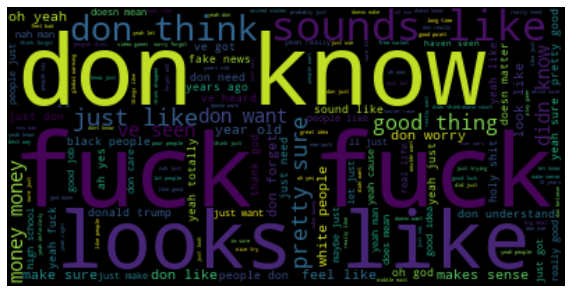

In [ ]:
## create word cloud from dataset
from wordcloud import WordCloud
wordcloud = WordCloud()
wordcloud.generate_from_frequencies(frequencies=bag_words)
plt.figure(figsize=(10,16))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# Modelling


### Functions to streamline building model and collecting results

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV

def model_build(model, X, y, params_tfi, params_model={}, n_splits=5, grid_search=False, param_grid = {}):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=123)
    tfi = TfidfVectorizer(**params_tfi)
    ml = model(**params_model)
    steps = [('tfi',tfi),('ml', ml)]
    pipe = Pipeline(steps) 
    
    if grid_search == False:
        pipe.fit(X, y) # only using fit as we include ML within the pipeline, if we need score or predict we need to
                          # individually call that method/function      
        val_score = cross_val_score(pipe, X, y, cv=kf)     
        print(f'CV score = {val_score.mean():.3f}')
    else:
        search = GridSearchCV(pipe, param_grid, n_jobs=-1)
        search.fit(X, y)
        print("Best parameter (CV score=%0.3f):" % search.best_score_)
        print(search.best_params_)
        pipe = search.best_estimator_
    y_pred = cross_val_predict(pipe, X, y, cv=kf)
    
    return pipe, y_pred

def model_results(y,y_pred):
    cm = confusion_matrix(y, y_pred)
    tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
    tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
    acc_score = accuracy_score(y, y_pred).round(2)
    recall = recall_score(y, y_pred).round(2)
    f1 = f1_score(y, y_pred, zero_division=1).round(2)
    print('','Accuracy Score:',acc_score,'\n','Recall Score:',recall,'\n','F1-Score:', f1)
    print()
    print('','TP:',tp,'\n','TN:',tn,'\n','FP:',fp,'\n','FN:',fn)
    display(sns.heatmap(cm,annot=True, cmap='jet'))

## Baseline Model

In [ ]:
X = cv.fit_transform(df['comment'])
y = df['label']

lr = LogisticRegression()
kf = KFold(n_splits=5, shuffle=True, random_state=123)
val_score = cross_val_score(lr, X, y, cv=kf)
y_pred = cross_val_predict(lr, X, y, cv=kf)
val_score.mean()

0.5791468515533869

##Logistic Regression model

CV score = 0.721
 Accuracy Score: 0.72 
 Recall Score: 0.68 
 F1-Score: 0.71

 TP: 345674 
 TN: 382614 
 FP: 122791 
 FN: 159694


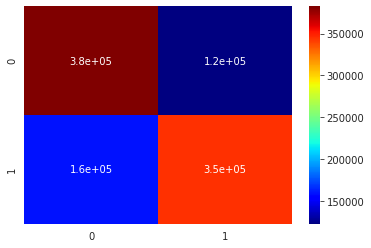

In [ ]:
#in this case re-assigning X and y variable as it will transform them in the function
X,y = df['comment'], df['label']
#applying tfi params according to a similar case found online which provided a substantial improvement from my baseline model
params_tfi = {'min_df': 2,'max_features':50000, 'ngram_range':(1,2)}

params_model = {'random_state': 17}
              
pipe_lr, y_pred_lr = model_build(LogisticRegression, X, y, params_model = params_model, params_tfi = params_tfi)
model_results(y,y_pred_lr)

## RandomForest Model


In [ ]:
from sklearn.ensemble import RandomForestClassifier
params_tfi = {'min_df': 0.05, 'max_df': 0.99,'max_features':5000, 'stop_words':'english', 'strip_accents': 'ascii',
                     'ngram_range':(1,2)}

param_grid = {'ml__max_depth': range(10,101,50),
              'ml__n_estimators': range(100,501,100),
              'tfi__min_df': np.linspace(0,0.05,6),
              'tfi__max_df': np.linspace(0.95,1.0,6),
              'tfi__max_features':range(10000,50001,10000)}
              
rf = RandomForestClassifier# no paranthesis since it is already included in the function

pipe_rf, y_pred_rf = model_build(rf, X, y, params_tfi, grid_search= True, param_grid= param_grid)

## Neural Network

In [ ]:
# Neural Network
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split


In [ ]:
params_tfi = {'min_df': 2,'max_features':5000, 'ngram_range':(1,2)}
tfi = TfidfVectorizer(**params_tfi)
sample_df = df.sample(250000)
X = tfi.fit_transform(sample_df['comment'])

y = sample_df['label']

X_train,X_test, y_train,y_test  = train_test_split(X,y, test_size = 0.15, random_state = 123)

In [ ]:
model = Sequential([
    Dense(64,  activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.5),
    Dense(1, activation = 'sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                320064    
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 320,129
Trainable params: 320,129
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(X_train.todense(), y_train, epochs=10, batch_size = 1000, validation_split = 0.15)

In [ ]:
plt.plot(history.history['accuracy'], label = 'Training')
plt.plot(history.history['val_accuracy'], label = 'Testing')
plt.legend()

In [ ]:
a = []
while(1):
  a.append('1')